# Flights Data Classification Task

The dataset contains the following columns:

- Airline
- Cabin Class
- Booking Class
- Duration of the trip (in minutes)
- Price (in euros)
- Country code
- Decreased Price (1 if this flight has seen its price decrease in the next 3 days, 0 otherwise)

## Load the Dataset

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('flights_data.csv', index_col="Unnamed: 0")

In [2]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24465 entries, 0 to 24464
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          24465 non-null  object 
 1   cabin class      24465 non-null  object 
 2   booking class    24465 non-null  object 
 3   duration         24465 non-null  int64  
 4   price            24465 non-null  float64
 5   country code     24465 non-null  int64  
 6   decreased price  24465 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 1.5+ MB


In [3]:
# Display the first few rows of the dataset
data.head()

,airline,cabin class,booking class,duration,price,country code,decreased price
0,AF,BUSINESS,C,595,7033.16,109,1
1,AF,ECONOMY,B,125,2248.51,109,1
2,AY,BUSINESS,C,1060,6250.83,172,1
3,AF,PREMIUM_ECO,A,1035,3553.39,109,1
4,AF,BUSINESS,C,935,9701.65,109,1


In [4]:
# Getting the counts for each class in decreased price
class_counts = data['decreased price'].value_counts()

# Printing the counts for each class
for c, count in class_counts.items():
    print(f"Class {c} has {count} samples")

Class 1 has 12244 samples
Class 0 has 12221 samples


## Data Cleaning (Negative Values, Missing Data and outliers)

In [5]:
# Check for negative values in numeric columns only
numeric_cols = data.select_dtypes(include=['int', 'float']).columns
negative_values = (data[numeric_cols] < 0).sum()
print("Negative values in each column:\n", negative_values)

# Replace negative values with NaN in numeric columns
data[numeric_cols] = data[numeric_cols].mask(data[numeric_cols] < 0, pd.NA)

# Check for missing data
missing_data = data.isnull().sum()
print("Missing data in each column:\n", missing_data)

# Fill missing values with the mean of the column
data['duration'] = data['duration'].fillna(data['duration'].mean())

# Verify that there are no more missing values
missing_data_after = data.isnull().sum()
print("Missing data after filling:\n", missing_data_after)

# Check for outliers using the IQR method on numeric columns
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside 1.5 * IQR
outliers = ((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers in each column:\n", outliers)

# Remove outliers based on numeric columns
data = data[~((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display the cleaned dataset
data.head()

Negative values in each column:
 duration           30
price               0
country code        0
decreased price     0
dtype: int64
Missing data in each column:
 airline             0
cabin class         0
booking class       0
duration           30
price               0
country code        0
decreased price     0
dtype: int64
Missing data after filling:
 airline            0
cabin class        0
booking class      0
duration           0
price              0
country code       0
decreased price    0
dtype: int64
Outliers in each column:
 duration             34
price               262
country code       5575
decreased price       0
dtype: int64


,airline,cabin class,booking class,duration,price,country code,decreased price
0,AF,BUSINESS,C,595.0,7033.16,109,1
1,AF,ECONOMY,B,125.0,2248.51,109,1
3,AF,PREMIUM_ECO,A,1035.0,3553.39,109,1
4,AF,BUSINESS,C,935.0,9701.65,109,1
5,BA,BUSINESS,R,755.0,7868.21,92,1


## Exploratory Data Analysis

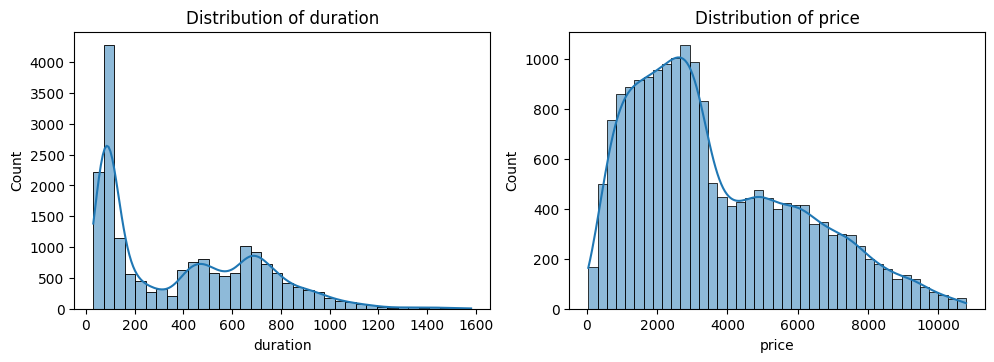

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns to avoid conversion errors
numeric_cols = data.select_dtypes(include=['number']).columns[:-1]
numeric_cols_1 = numeric_cols.drop('country code')

# Plot the distribution of each numeric feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_cols_1, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

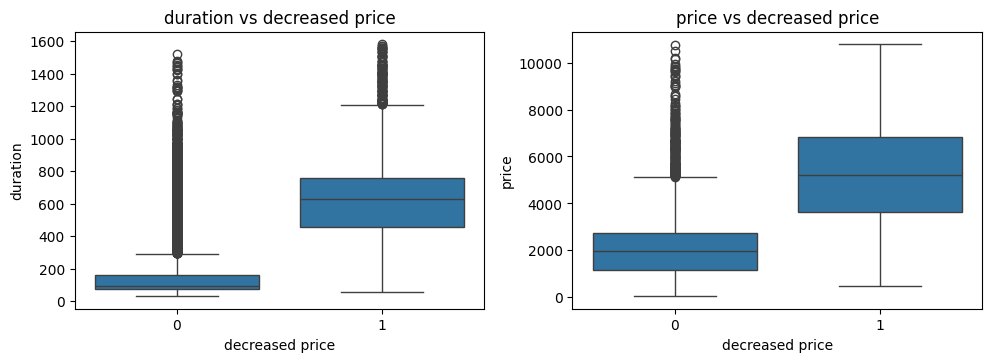

In [7]:
# Plot the relationship between each numeric feature and the target variable 'decreased price'
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_cols_1, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='decreased price', y=column, data=data)
    plt.title(f'{column} vs decreased price')
plt.tight_layout()
plt.show()

In [8]:
import plotly.figure_factory as ff

# drop the country code column and airline column
data_1 = data.drop('country code', axis=1)

# Compute the correlation matrix
corr_matrix = data_1.corr(numeric_only=True)

# Heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    colorscale='YlGnBu',
    showscale=True,
    annotation_text=corr_matrix.round(2).values
)

fig.update_layout(title='Correlation Heatmap')
fig.show()

## Categorical Label Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in ['airline', 'cabin class', 'booking class']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data.head()    

,airline,cabin class,booking class,duration,price,country code,decreased price
0,20,0,2,595.0,7033.16,109,1
1,20,1,1,125.0,2248.51,109,1
3,20,3,0,1035.0,3553.39,109,1
4,20,0,2,935.0,9701.65,109,1
5,32,0,17,755.0,7868.21,92,1


## Train-Test Split(Ensuring a balanced representation of classes)

In [10]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data.drop('decreased price', axis=1)
y = data['decreased price']

# Split the data into training and testing sets with a balanced representation of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Verify the distribution of the target variable in the training and testing sets
print("Distribution of target variable in training set:\n", y_train.value_counts(normalize=True))
print("Distribution of target variable in testing set:\n", y_test.value_counts(normalize=True))

Training set shape: (14905, 6) (14905,)
Testing set shape: (3727, 6) (3727,)
Distribution of target variable in training set:
 decreased price
0    0.501711
1    0.498289
Name: proportion, dtype: float64
Distribution of target variable in testing set:
 decreased price
0    0.501744
1    0.498256
Name: proportion, dtype: float64


## Building and Evaluating Classification Models

### Random Forest Classifier

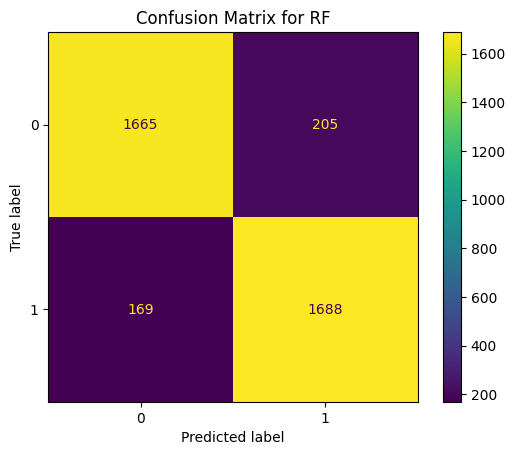


Classification Report for RF:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1870
           1       0.89      0.91      0.90      1857

    accuracy                           0.90      3727
   macro avg       0.90      0.90      0.90      3727
weighted avg       0.90      0.90      0.90      3727

Accuracy for RF: 0.8996511939898041
Precision for RF: 0.8917062863180137
Recall for RF: 0.908992999461497
F1-score for RF: 0.9002666666666667


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = rf_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()
plt.title('Confusion Matrix for RF') 
plt.show()

# Evaluate the performance of the model
print("\nClassification Report for RF:\n", classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy for RF: {accuracy_rf}")
print(f"Precision for RF: {precision_rf}")
print(f"Recall for RF: {recall_rf}")
print(f"F1-score for RF: {f1_rf}")


Best Parameters for RandomForestClassifier: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score for RandomForestClassifier: 0.8992955384099295


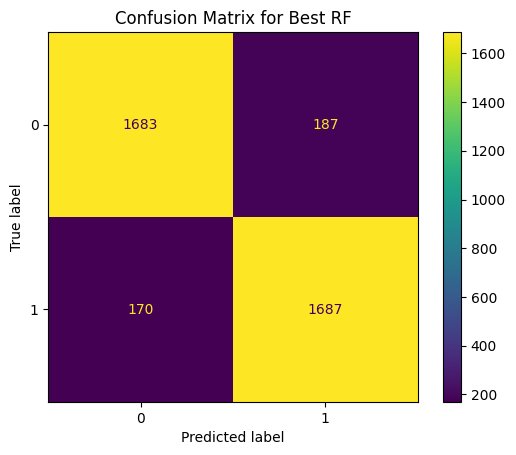


Classification Report for Best RF:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1870
           1       0.90      0.91      0.90      1857

    accuracy                           0.90      3727
   macro avg       0.90      0.90      0.90      3727
weighted avg       0.90      0.90      0.90      3727

Accuracy for Best RF: 0.9042125033539039
Precision for Best RF : 0.9002134471718249
Recall for Best RF: 0.9084544964997308
F1-score for Best RF: 0.9043151969981238


In [14]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best Parameters for RandomForestClassifier:", best_params_rf)
print("Best Cross-Validation Score for RandomForestClassifier:", best_score_rf)

# Train the model with the best parameters
best_rf_classifier = grid_search_rf.best_estimator_

# Make predictions on the testing set
y_pred_best_rf = best_rf_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best_rf)).plot()
plt.title('Confusion Matrix for Best RF')
plt.show()

# Evaluate the performance of the tuned model
print("\nClassification Report for Best RF:\n", classification_report(y_test, y_pred_best_rf))

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

# Print the evaluation metrics
print(f"Accuracy for Best RF: {accuracy_best_rf}")
print(f"Precision for Best RF : {precision_best_rf}")
print(f"Recall for Best RF: {recall_best_rf}")
print(f"F1-score for Best RF: {f1_best_rf}")

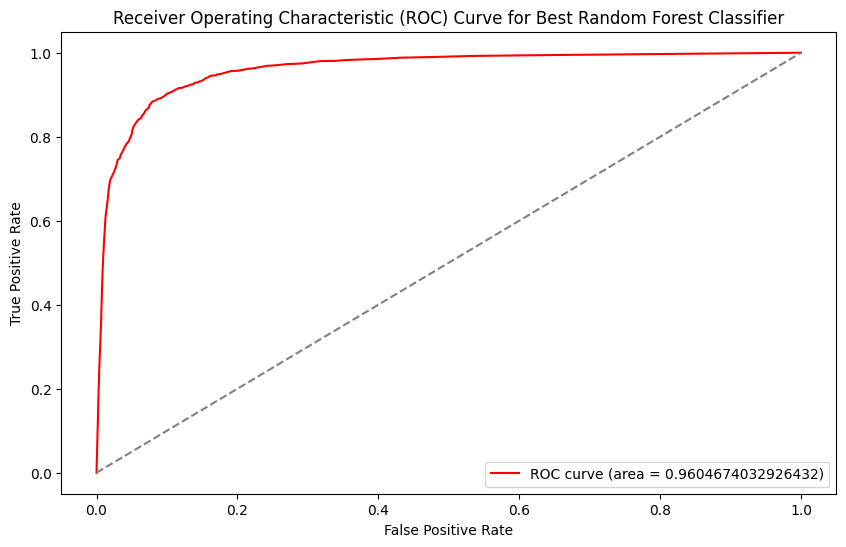

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

### Gradient Boosting Classifier

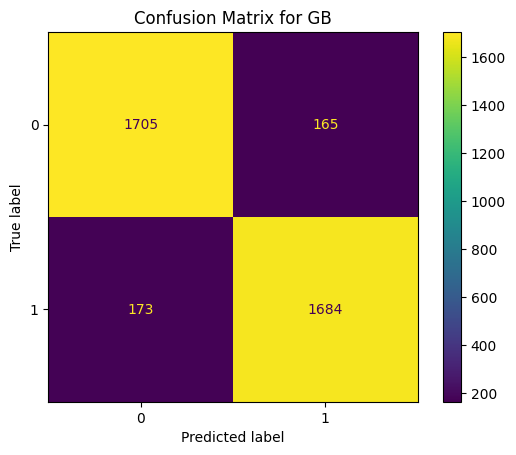


Classification Report for GB:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1870
           1       0.91      0.91      0.91      1857

    accuracy                           0.91      3727
   macro avg       0.91      0.91      0.91      3727
weighted avg       0.91      0.91      0.91      3727

Accuracy for GB: 0.9093104373490744
Precision for GB: 0.9107625743645213
Recall for GB: 0.9068389876144318
F1-score for GB: 0.9087965461413924


In [17]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the model on the training set
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_gb = gb_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_gb)).plot()
plt.title('Confusion Matrix for GB')
plt.show()

# Evaluate the performance of the model
print("\nClassification Report for GB:\n", classification_report(y_test, y_pred_gb))

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

# Print the evaluation metrics
print(f"Accuracy for GB: {accuracy_gb}")
print(f"Precision for GB: {precision_gb}")
print(f"Recall for GB: {recall_gb}")
print(f"F1-score for GB: {f1_gb}")

Best Parameters: {'learning_rate': 0.2, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'n_estimators': 200}
Best Cross-Validation Score: 0.9010399194901041


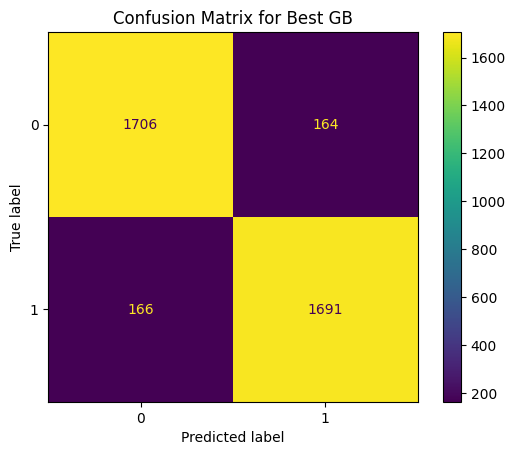


Classification Report for Best GB:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1870
           1       0.91      0.91      0.91      1857

    accuracy                           0.91      3727
   macro avg       0.91      0.91      0.91      3727
weighted avg       0.91      0.91      0.91      3727

Accuracy for Best GB: 0.9114569358733566
Precision for Best GB: 0.9115902964959569
Recall for Best GB: 0.9106085083467959
F1-score for Best GB: 0.9110991379310345


In [20]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_leaf_nodes': [31, 41, 51],
    'min_samples_leaf': [20, 30, 40]
}

# Initialize the GridSearchCV object
grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Best Parameters:", best_params_gb)
print("Best Cross-Validation Score:", best_score_gb)

# Train the model with the best parameters
best_gb_classifier = grid_search_gb.best_estimator_

# Make predictions on the testing set
y_pred_best_gb = best_gb_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best_gb)).plot()
plt.title('Confusion Matrix for Best GB')
plt.show()

# Evaluate the performance of the model
print("\nClassification Report for Best GB:\n", classification_report(y_test, y_pred_best_gb))

accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
precision_best_gb = precision_score(y_test, y_pred_best_gb)
recall_best_gb = recall_score(y_test, y_pred_best_gb)
f1_best_gb = f1_score(y_test, y_pred_best_gb)

# Print the evaluation metrics
print(f"Accuracy for Best GB: {accuracy_best_gb}")
print(f"Precision for Best GB: {precision_best_gb}")
print(f"Recall for Best GB: {recall_best_gb}")
print(f"F1-score for Best GB: {f1_best_gb}")

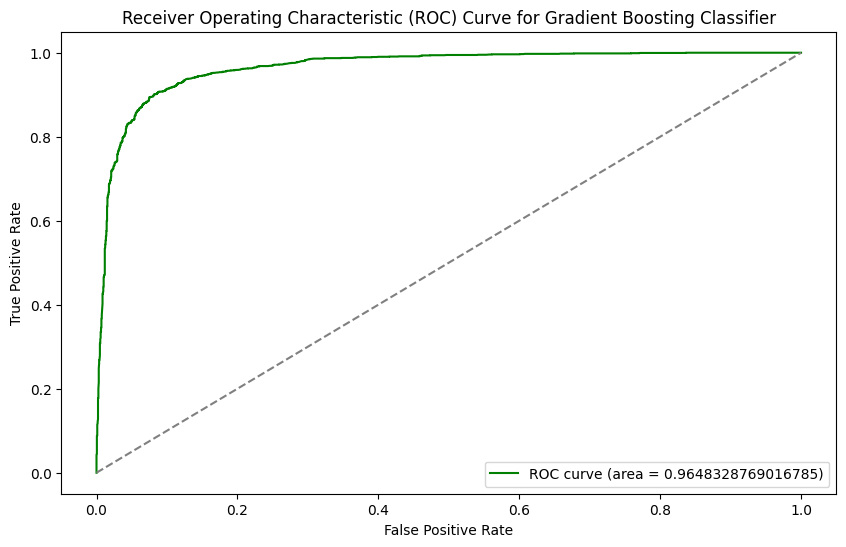

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_pred_prob_gb = gb_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb)

# Compute the AUC score
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_gb, tpr_gb, color='green', label=f'ROC curve (area = {roc_auc_gb})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()

### MLP Classifier

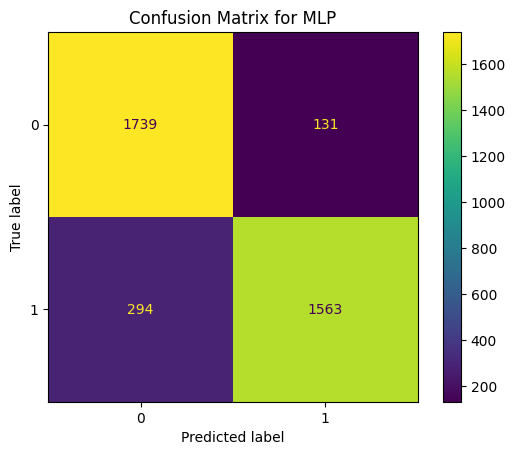


Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1870
           1       0.92      0.84      0.88      1857

    accuracy                           0.89      3727
   macro avg       0.89      0.89      0.89      3727
weighted avg       0.89      0.89      0.89      3727

Accuracy for MLP: 0.8859672658975047
Precision for MLP: 0.922668240850059
Recall for MLP: 0.8416801292407108
F1-score for MLP: 0.8803154041115179


In [22]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

# Train the model on the training set
mlp_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_mlp = mlp_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp)).plot()
plt.title('Confusion Matrix for MLP')
plt.show()

# Evaluate the performance of the model
print("\nClassification Report for MLP:\n", classification_report(y_test, y_pred_mlp))

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

# Print the evaluation metrics
print(f"Accuracy for MLP: {accuracy_mlp}")
print(f"Precision for MLP: {precision_mlp}")
print(f"Recall for MLP: {recall_mlp}")
print(f"F1-score for MLP: {f1_mlp}")

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validation Score for MLPClassifier: 0.8864139550486414


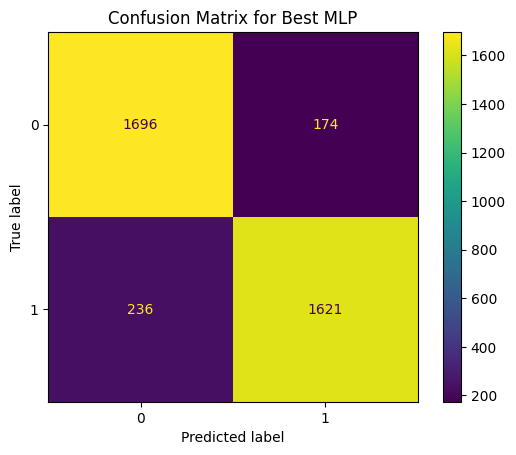


Classification Report for Best MLP:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1870
           1       0.90      0.87      0.89      1857

    accuracy                           0.89      3727
   macro avg       0.89      0.89      0.89      3727
weighted avg       0.89      0.89      0.89      3727

Accuracy for Best MLP: 0.8899919506305339
Precision for Best MLP: 0.9030640668523677
Recall for Best MLP: 0.8729133010231557
F1-score for Best MLP: 0.8877327491785323


In [23]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

# Initialize the GridSearchCV object for MLPClassifier
grid_search_mlp = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid_mlp, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the data
grid_search_mlp.fit(X_train, y_train)

# Get the best parameters and best score
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_

print("Best Parameters for MLPClassifier:", best_params_mlp)
print("Best Cross-Validation Score for MLPClassifier:", best_score_mlp)

# Train the model with the best parameters
best_mlp_classifier = grid_search_mlp.best_estimator_

# Make predictions on the testing set
y_pred_best_mlp = best_mlp_classifier.predict(X_test)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best_mlp)).plot()
plt.title('Confusion Matrix for Best MLP')
plt.show()

# Evaluate the performance of the model
print("\nClassification Report for Best MLP:\n", classification_report(y_test, y_pred_best_mlp))

accuracy_best_mlp = accuracy_score(y_test, y_pred_best_mlp)
precision_best_mlp = precision_score(y_test, y_pred_best_mlp)
recall_best_mlp = recall_score(y_test, y_pred_best_mlp)
f1_best_mlp = f1_score(y_test, y_pred_best_mlp)

# Print the evaluation metrics
print(f"Accuracy for Best MLP: {accuracy_best_mlp}")
print(f"Precision for Best MLP: {precision_best_mlp}")
print(f"Recall for Best MLP: {recall_best_mlp}")
print(f"F1-score for Best MLP: {f1_best_mlp}")

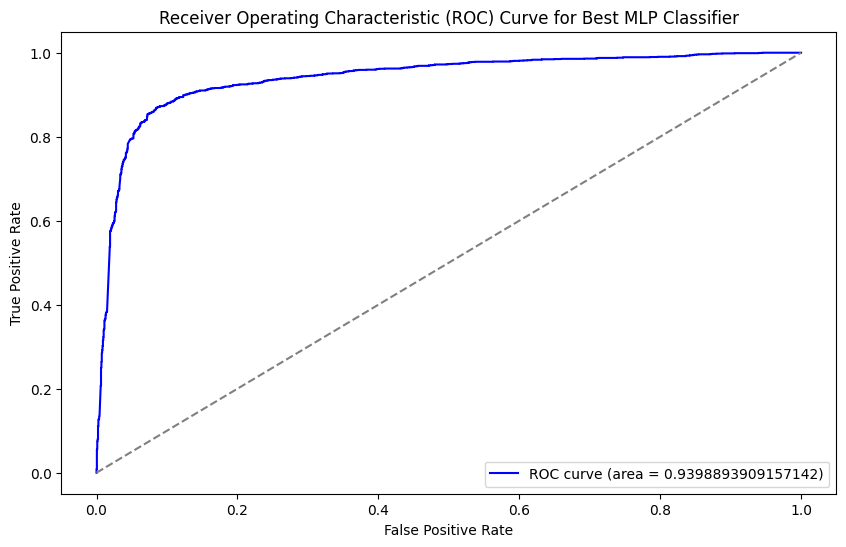

In [24]:
# Get the predicted probabilities for the positive class
y_pred_prob_best_mlp = best_mlp_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr_best_mlp, tpr_best_mlp, thresholds_best_mlp = roc_curve(y_test, y_pred_prob_best_mlp)

# Compute the AUC score
roc_auc_best_mlp = roc_auc_score(y_test, y_pred_prob_best_mlp)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_best_mlp, tpr_best_mlp, color='blue', label=f'ROC curve (area = {roc_auc_best_mlp})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best MLP Classifier')
plt.legend(loc='lower right')
plt.show()

## Comparsion of the models

In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

colors = ['red', 'green', 'blue']
models = ['Random Forest Classifier (RF)', 'Gradient Boosting Classifier (GB)', 'MLP Classifier (MLP)']
accuracy_values = [accuracy_best_rf, accuracy_best_gb, accuracy_best_mlp]
precision_values = [precision_best_rf, precision_best_gb, precision_best_mlp]
recall_values = [recall_best_rf, recall_best_gb, recall_best_mlp]
f1_values = [f1_best_rf, f1_best_gb, f1_best_mlp]

# Subplots for MSE and R-squared with updated colors
fig = make_subplots(rows=2, cols=2, subplot_titles=('Accuracy', 'Precision', 'Recall', 'F1 Score'))

# Accuracy subplot
fig.add_trace(
    go.Bar(x=models, y=accuracy_values, marker_color=colors, name='Accuracy'),
    row=1, col=1
)

# Precsion subplot
fig.add_trace(
    go.Bar(x=models, y=precision_values, marker_color=colors, name='Precision'),
    row=1, col=2
)

# Recall subplot
fig.add_trace(
    go.Bar(x=models, y=recall_values, marker_color=colors, name='Recall'),
    row=2, col=1
)

# F1 Score subplot
fig.add_trace(
    go.Bar(x=models, y=f1_values, marker_color=colors, name='F1 Score'),
    row=2, col=2
)

# Layout adjustments
fig.update_layout(
    title_text='Comparison of Model Performance Metrics',
    showlegend=False,
    height=1000,
    width=900,
)

fig.show()

# Result
Gradient Boosting Classifier classifies better compared to Random Forest Classifier and MLP Classifier, with the highest evaluation scores.